In [ ]:
#!wget https://media.githubusercontent.com/media/juliacfaria/arquivosTPDados/main/DadosLimpos/dadosLimpos2019.csv

In [ ]:
#!wget https://media.githubusercontent.com/media/juliacfaria/arquivosTPDados/main/DadosLimpos/dadosLimpos2020.csv

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn import metrics
from sklearn import svm
import matplotlib.patches as mpatches

A função plotPredictSuper será usada para plotar os gráficos relacionados ao aprendizado supervisionado, apresentando uma boa base para uma comparação visual entre o resultado do modelo e os dados reais 

In [7]:

def plotPredictSuper(feature1, feature2, X_test, Y_test, Y_Model):
    # Ajusta o tamanho do gráfico a ser plotado
    plt.figure(figsize=(14, 8))

    green_patch = mpatches.Patch(color='green', label='Aprovado')
    red_patch = mpatches.Patch(color='red', label='Recusado')
    blue_patch = mpatches.Patch(color='blue', label='Outro')

    cmap_real = np.array(['green','red', 'blue'])

    # Agrupamentos originais/reais
    plt.subplot(1, 2, 1)
    plt.scatter(x=X_test[feature1], y=X_test[feature2],  c=cmap_real[Y_test], s=40)
    plt.title('Agrupamento Real')
    plt.xlabel(feature1)
    plt.ylabel(feature2)

    
    plt.legend(handles=[ green_patch, red_patch, blue_patch])

    #Modelo
    plt.subplot(1, 2, 2)

    plt.scatter(x=X_test[feature1], y=X_test[ feature2],  c=cmap_real[Y_Model], s=40)
    plt.title('Agrupamento do Aprendizado')
    plt.xlabel(feature1)
    plt.ylabel(feature2)
    plt.legend(handles=[red_patch, green_patch, blue_patch])

    plt.show()

A Função getStatistics será utilizada para apresentar os valores de acuracia, precisão, e revogação de um modelo. Além disso ela também apresentará a matriz confusa da mesma.

In [15]:
def getStatistics(y_test, y_pred):
    print(f"Acuracia:{accuracy_score(y_test, y_pred) * 100:.2f}%")
    print(f"Precisão: {precision_score(y_test, y_pred, average='macro')* 100:.2f}%")
    print(f"Revogação: {recall_score(y_test, y_pred, average='macro')* 100:.2f}% ")
    print("\nMatriz Confusa: ")
    print(confusion_matrix(y_test, y_pred), "\n") 

In [16]:
def getColor(x):
  if(x == 'Aceito' ):
    return 0
  elif(x == 'Recusado'):
    return 1
  else:
    return 2

### Leitura dos dados


In [8]:
fies2019 = pd.read_csv('./dadosLimpos2019.csv', encoding="UTF-8")

In [9]:
fies2020 = pd.read_csv('./dadosLimpos2020.csv', encoding="UTF-8")

In [11]:
fies2019.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 232432 entries, 0 to 232431
Data columns (total 30 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   ID do estudante                 232432 non-null  int64  
 1   Sexo                            232432 non-null  object 
 2   Data de Nascimento              232432 non-null  object 
 3   UF de residência                232432 non-null  object 
 4   Etnia/Cor                       232432 non-null  object 
 5   Pessoa com deficiência?         232432 non-null  object 
 6   Ano conclusão ensino médio      232432 non-null  int64  
 7   Concluiu curso superior?        232432 non-null  object 
 8   Nº de membros Grupo Familiar    232432 non-null  int64  
 9   Renda familiar mensal bruta     232432 non-null  float64
 10  Renda mensal bruta per capita   232432 non-null  float64
 11  UF                              232432 non-null  object 
 12  Área do conhecim

In [10]:
fies2020.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 182425 entries, 0 to 182424
Data columns (total 30 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   ID do estudante                 182425 non-null  int64  
 1   Sexo                            182425 non-null  object 
 2   Data de Nascimento              182425 non-null  object 
 3   UF de residência                182425 non-null  object 
 4   Etnia/Cor                       182425 non-null  object 
 5   Pessoa com deficiência?         182425 non-null  object 
 6   Ano conclusão ensino médio      182425 non-null  int64  
 7   Concluiu curso superior?        182425 non-null  object 
 8   Nº de membros Grupo Familiar    182425 non-null  int64  
 9   Renda familiar mensal bruta     182425 non-null  float64
 10  Renda mensal bruta per capita   182425 non-null  float64
 11  UF                              182425 non-null  object 
 12  Área do conhecim

# Prever se um inscrito será aceito ou não

## Em 2019

Avaliando o conjunto de dados de 2019

### Facilitando a análise

Para facilitar a análise dos resultados obtidos, visto que a situação da inscrição do FIES possui diversos estados possíveis, estes foram agrupados em opções menores, sendo elas "Aceito", "Recusado", "Outro".

In [12]:
def classificar(situacao):
    if situacao in incricao["Aceito"]:
        return "Aceito"
    elif situacao in incricao["Recusado"]:
        return "Recusado"
    else:
        return "Outro"
    

incricao = {"Aceito":{'CONTRATADA', 'PRÉ-SELECIONADO'},
            "Recusado":{'NÃO CONTRATADO', 'REJEITADA PELA CPSA', 'OPÇÃO NÃO CONTRATADA' },
            "Outro":{'LISTA DE ESPERA','PARTICIPACAO CANCELADA PELO CANDIDATO' }}

fies2019['Situação Inscrição Fies'] = fies2019['Situação Inscrição Fies'].apply(lambda x: classificar(x))

### Definindo colunas de interesse para aplicar os algoritmos de aprendizado supervisionado

Observer que as colunas foram definidas com base no que a equipe deduziu ser coerente no contexto da situação da inscrição do fies

In [17]:
cols_interesse = [
                "Nº de membros Grupo Familiar",
                "Renda familiar mensal bruta",
                "Renda mensal bruta per capita", 
                "Opções de cursos da inscrição",
                "Sexo", 
                "UF de residência", "Etnia/Cor", "Pessoa com deficiência?", "Concluiu curso superior?",    
                "Ano do Enem", "Média nota Enem", "Redação", "Matemática e suas Tecnologias", "Linguagens, Códigos e suas Tec",
                "Ciências Natureza e suas Tec",   "Ciências Humanas e suas Tec", 
                  ]
     
fies2019_X = fies2019[cols_interesse]
fies2019_X = pd.get_dummies(fies2019_X, columns=["Sexo", "UF de residência", "Etnia/Cor", "Pessoa com deficiência?", "Concluiu curso superior?"])



fies2019_Y = fies2019["Situação Inscrição Fies"]

X_train, X_test, Y_train, Y_test = train_test_split(
    fies2019_X,
    fies2019_Y,
    test_size=0.3,
    random_state=0
)

#Usado para plotar no grafico, passo categoria para númerico

Y_Result = list(Y_test.apply(lambda x: getColor(x)))

### KNN

Inicialmente será aplicado o algoritmo KNN, o qual foi aprendido em sala de aula e se apresentou especialmente útil neste contexto do aprendizado supervisionado

In [18]:
knn = KNeighborsClassifier()
knn.fit(X_train, Y_train)

knn_Y_predicted = knn.predict(X_test)

knn_accuracy = np.sum(knn_Y_predicted == Y_test) / len(Y_test)

#### Avaliando estatísticas do modelo gerado

In [19]:
getStatistics(Y_test, knn_Y_predicted)

Acuracia:65.99%
Precisão: 47.06%
Revogação: 46.59% 

Matriz Confusa: 
[[  419  1420  5820]
 [  735  9155  7429]
 [ 1760  6550 36442]] 



#### Avaliando de forma visual

Para possibilitar que uma análise mais visual fosse gerada, gráficos foram plotados, onde os atributos comparados são informados para a função "plotPredictSuper", a qual foi criada previamente, no início do documento

In [20]:
#Tratando os resultados para plotar grafico

Y_knn = []

for i in range(len(knn_Y_predicted)):
    Y_knn.append(getColor(knn_Y_predicted[i]))

##### Nº de membros Grupo Familiar x Renda familiar mensal bruta

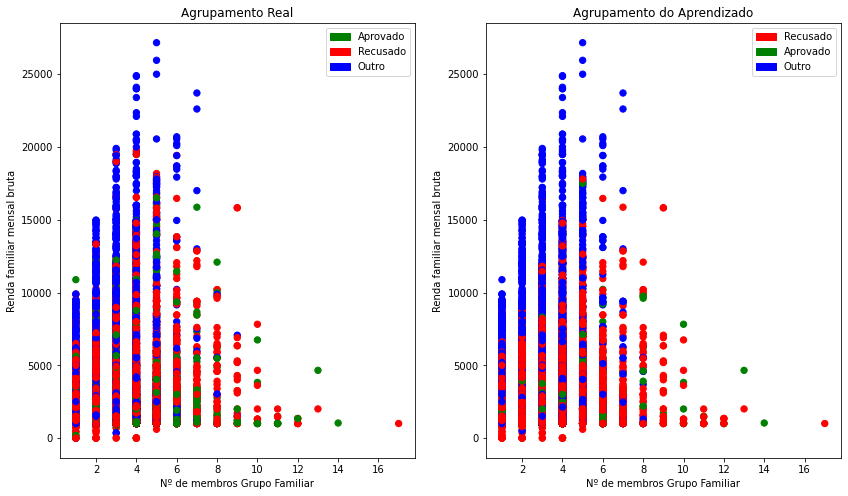

In [21]:
plotPredictSuper("Nº de membros Grupo Familiar", "Renda familiar mensal bruta", X_test, Y_Result, Y_knn)

##### Ano do Enem x Média nota Enem

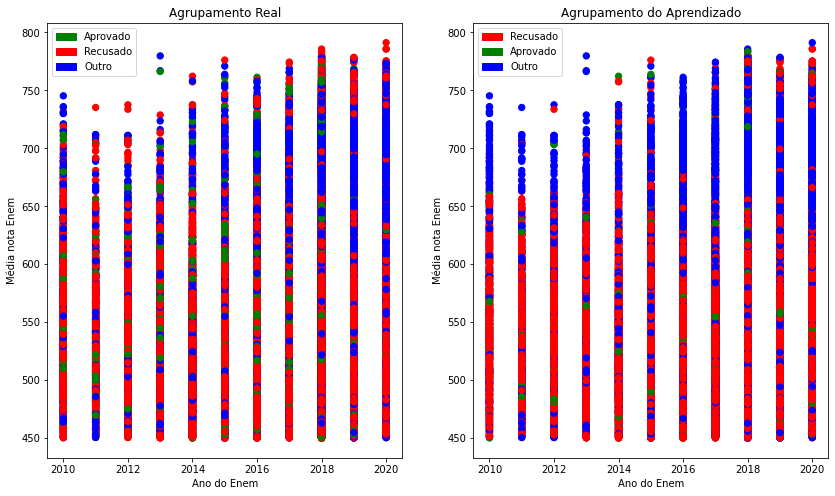

In [22]:
plotPredictSuper("Ano do Enem", "Média nota Enem", X_test, Y_Result, Y_knn)

##### Redação x Média nota Enem

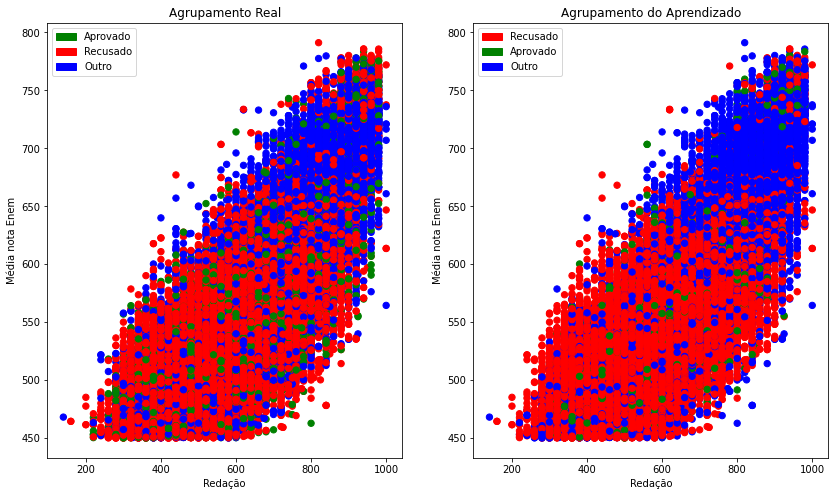

In [23]:
plotPredictSuper("Redação", "Média nota Enem", X_test, Y_Result, Y_knn)

### Árvore de decisão

Visando avaliar outros algoritmos de aprendizado supervisionado, utilizou-se, também, o de Árvore de Decisão, o qual foi também ensinado em aulas desta disciplina

In [27]:
from sklearn import tree

dtc=tree.DecisionTreeClassifier()
dtc.fit(X_train,Y_train)

dtc_Y_predicted = dtc.predict(X_test)

#### Avaliando estatísticas do modelo gerado

In [28]:
getStatistics(Y_test, dtc_Y_predicted)

Acuracia:65.96%
Precisão: 52.97%
Revogação: 53.26% 

Matriz Confusa: 
[[ 2030  1457  4172]
 [ 1452  9904  5963]
 [ 4366  6328 34058]] 



#### Avaliando de forma visual

Para possibilitar que uma análise mais visual fosse gerada, gráficos foram plotados, onde os atributos comparados são informados para a função "plotPredictSuper", a qual foi criada previamente, no início do documento

In [30]:
#Tratando os resultados para plotar grafico

Y_dtc = []

for i in range(len(dtc_Y_predicted )):
    Y_dtc.append(getColor(dtc_Y_predicted[i]))
   

##### Nº de membros Grupo Familiar x Renda familiar mensal bruta

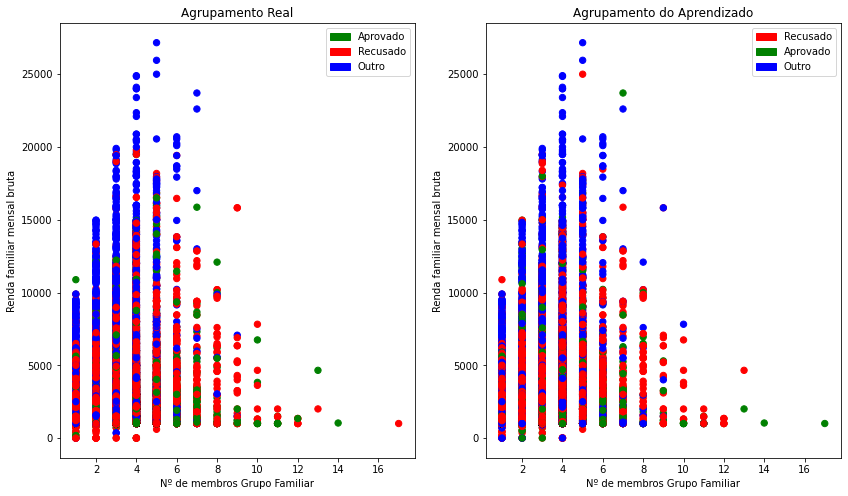

In [31]:
plotPredictSuper("Nº de membros Grupo Familiar", "Renda familiar mensal bruta", X_test, Y_Result, Y_dtc)

##### Redação x Média nota Enem

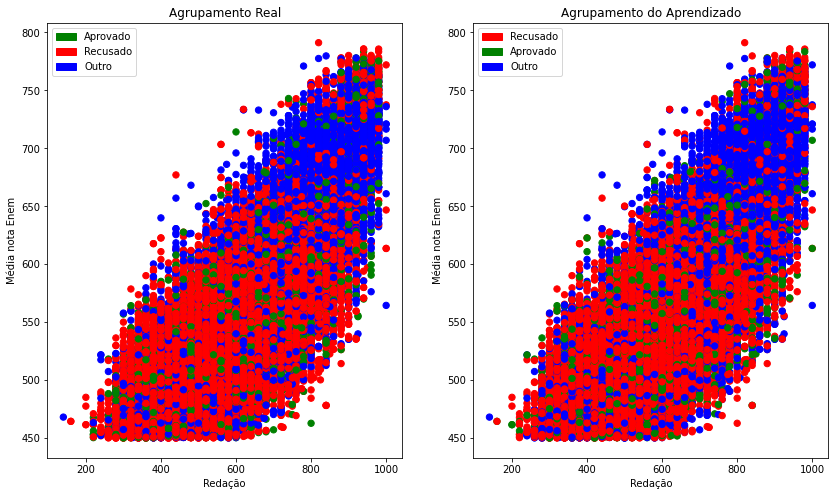

In [33]:
plotPredictSuper("Redação", "Média nota Enem", X_test, Y_Result, Y_dtc)

### Visando aplicar outros algoritmos de aprendizado supervisionado, fez-se um novo conjunto de testes com novas colunas de interesse

In [41]:
cols_interesse = [
                "Nº de membros Grupo Familiar",
                "Renda familiar mensal bruta",
                "Renda mensal bruta per capita", 
                "Opções de cursos da inscrição",
                "Sexo",  "UF de residência", "Etnia/Cor", "Pessoa com deficiência?", "Concluiu curso superior?"]
     
fies2019_X = fies2019[cols_interesse]
fies2019_X = pd.get_dummies(fies2019_X, columns=["Sexo", "UF de residência", "Etnia/Cor", "Pessoa com deficiência?", "Concluiu curso superior?"])


fies2019_Y = fies2019["Situação Inscrição Fies"]

X_train, X_test, Y_train, Y_test = train_test_split(
    fies2019_X,
    fies2019_Y,
    test_size=0.3,
    random_state=0
)

#Usado para plotar no grafico, passo categoria para númerico

Y_Result = list(Y_test.apply(lambda x: getColor(x)))

### SVM

Aplicando um outro algoritmo, também citado em aula, o qual é denominado como SVM

In [42]:
from sklearn import svm

svm = svm.SVC(kernel='linear', max_iter=10000)
svm.fit(X_train, Y_train)

svm_Y_predicted = svm.predict(X_test)
svm_accuracy = np.sum(svm_Y_predicted == Y_test) / len(Y_test)

/home/juliacfaria/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


#### Avaliando estatísticas do modelo gerado

In [43]:
getStatistics(Y_test, svm_Y_predicted)

Acuracia:12.20%
Precisão: 36.17%
Revogação: 33.50% 

Matriz Confusa: 
[[ 7516     2   141]
 [16660    46   613]
 [43745    62   945]] 



#### Avaliando de forma visual

Para possibilitar que uma análise mais visual fosse gerada, gráficos foram plotados, onde os atributos comparados são informados para a função "plotPredictSuper", a qual foi criada previamente, no início do documento

In [44]:
#Tratando os resultados para plotar grafico

Y_svm = []

for i in range(len(svm_Y_predicted )):
    Y_svm.append(getColor(svm_Y_predicted[i]))
   

##### Nº de membros Grupo Familiar x Renda familiar mensal bruta

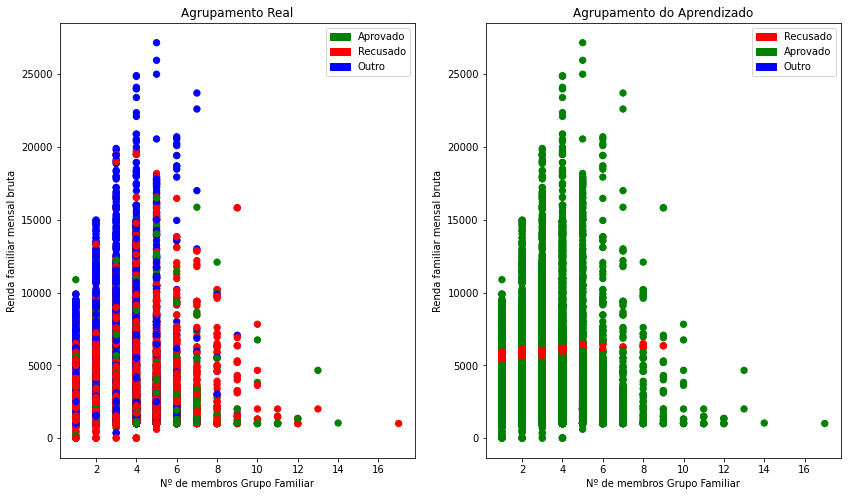

In [45]:
plotPredictSuper("Nº de membros Grupo Familiar", "Renda familiar mensal bruta", X_test, Y_Result, Y_svm)

##### Renda mensal bruta per capita x Opções de cursos da inscrição

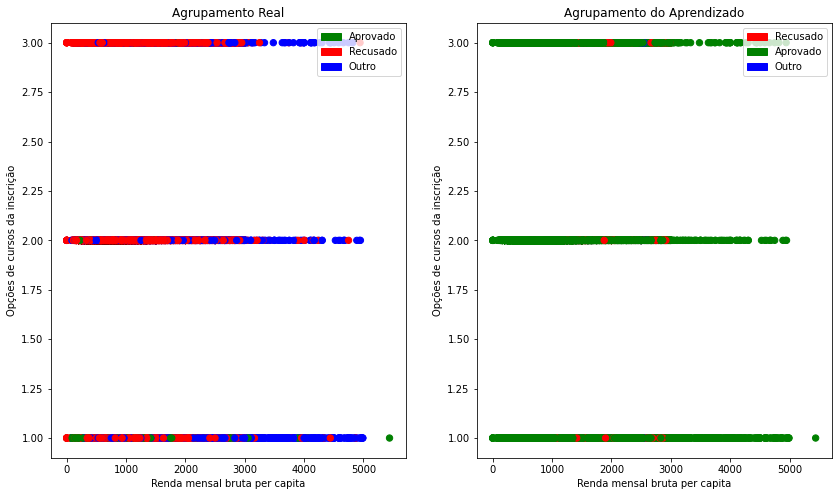

In [46]:
plotPredictSuper("Renda mensal bruta per capita","Opções de cursos da inscrição", X_test, Y_Result, Y_svm)

### PCA

* É basicamente um procedimento não dependente no qual reduz o espaço de atributos de um grande número de variáveis ​​para um menor número de fatores.

* PCA é basicamente um processo de redução de dimensão, mas não há garantia de que a dimensão seja interpretável.

* principal tarefa neste PCA é selecionar um subconjunto de variáveis ​​de um conjunto maior, com base em quais variáveis ​​originais têm a correlação mais alta com o valor principal.

In [47]:
# performing preprocessing part
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
 
X_train = sc.fit_transform(X_train)
X_testl = sc.transform(X_test)

In [48]:

from sklearn.decomposition import PCA
 
pca = PCA(n_components = 2)
 
X_train = pca.fit_transform(X_train)
X_testl = pca.transform(X_testl)
 
explained_variance = pca.explained_variance_ratio_

In [49]:

from sklearn.linear_model import LogisticRegression 
 
classifier = LogisticRegression(random_state = 0)
classifier.fit(X_train, Y_train)

pca_Y_predicted = classifier.predict(X_testl)

#### Avaliando estatísticas do modelo gerado

In [51]:
getStatistics(Y_test, pca_Y_predicted)

Acuracia:64.92%


/home/juliacfaria/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Precisão: 43.08%
Revogação: 34.86% 

Matriz Confusa: 
[[    0    84  7575]
 [    0   966 16353]
 [    0   452 44300]] 



#### Avaliando de forma visual

Para possibilitar que uma análise mais visual fosse gerada, gráficos foram plotados, onde os atributos comparados são informados para a função "plotPredictSuper", a qual foi criada previamente, no início do documento

In [52]:

Y_pca = []

for i in range(len(pca_Y_predicted )):
    Y_pca.append(getColor(pca_Y_predicted[i]))

##### Nº de membros Grupo Familiar x Renda familiar mensal bruta

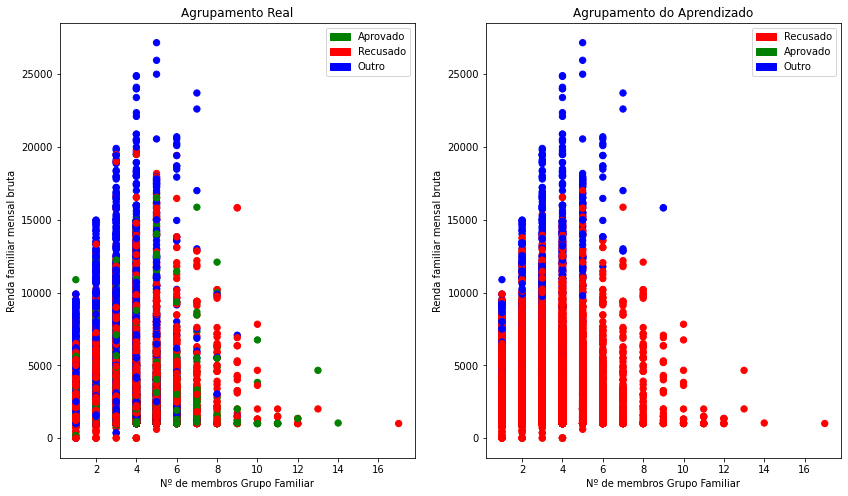

In [53]:
plotPredictSuper("Nº de membros Grupo Familiar", "Renda familiar mensal bruta", X_test, Y_Result, Y_pca)

##### Renda mensal bruta per capita x Opções de cursos da inscrição

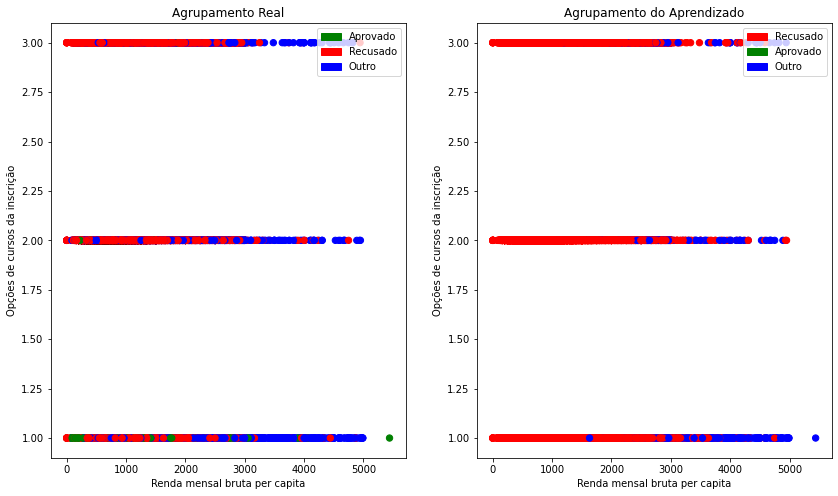

In [54]:
plotPredictSuper("Renda mensal bruta per capita","Opções de cursos da inscrição", X_test, Y_Result, Y_pca)

#### Conclusão

A partir dos algoritmos avaliados, pode-se concluir que os que geraram melhores modelos foram o KNN e o da árvore de decisão, o que pode ser observado pelos gráficos comparativos entre os valores previstos e valores reais, bem como nas estatísticas geradas acerca de cada modelo.

### Aprendizado não supervisionado

Neste momento, aplicaremos algoritmos de aprendizado não supervisionado para visualizar se é possível agrupar os dados da situação do FIES em clusters bem definidos

In [55]:

def plotPredictNoSuper(feature1, feature2, df, target, fx, label):
    # Ajusta o tamanho do gráfico a ser plotado
    plt.figure(figsize=(14, 7))
    
    green_patch = mpatches.Patch(color='green', label='Aprovado')
    red_patch = mpatches.Patch(color='red', label='Recusado')
    blue_patch = mpatches.Patch(color='blue', label='Outro')
        
    cmap_real = np.array(['green','red', 'blue'])

    # Agrupamentos originais/reais
    plt.subplot(1, 2, 1)
    plt.scatter(x=df[feature1], y=df[feature2],  c=cmap_real[df[target].apply(lambda x: fx(x))], s=40)
    plt.title('Agrupamento Real')
    plt.xlabel(feature1)
    plt.ylabel(feature2)
    plt.legend(handles=[ green_patch, red_patch, blue_patch])
    #Modelo
    plt.subplot(1, 2, 2)

    plt.scatter(x=df[feature1], y=df[ feature2],  c=cmap_real[label], s=40)
    plt.title('Agrupamento do Aprendizado')
    plt.xlabel(feature1)
    plt.ylabel(feature2)

    plt.show()

#### K-Means

Este algoritmo, conforme visto em aula, é um algoritmo muito bom. Além disso, ele é vantajoso no contexto em questão visto que é possível definir a quantidade de cluesters desejado que, no caso, equivale à quantidade de categorias utilizadas na situação da inscrição do FIES

In [56]:
from sklearn import datasets, cluster

     
X = fies2019_X

k_means = cluster.KMeans(n_clusters=3)
k_means.fit(X)



KMeans(n_clusters=3)

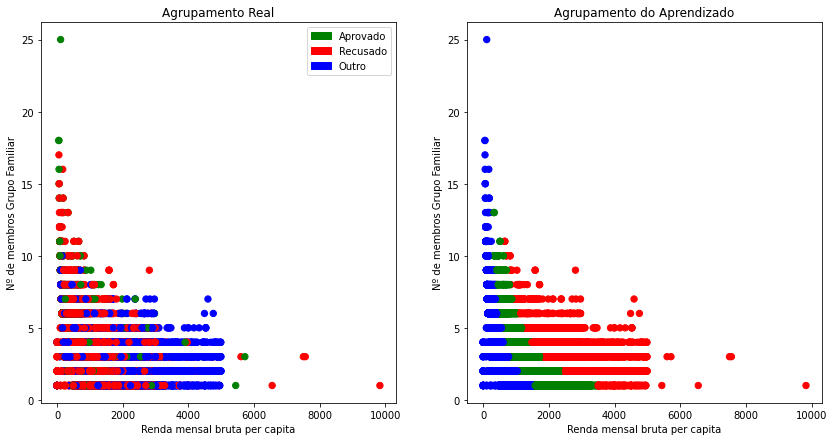

In [57]:
plotPredictNoSuper("Renda mensal bruta per capita",
                    "Nº de membros Grupo Familiar",
                    fies2019,
                    "Situação Inscrição Fies",
                    getColor,
                    k_means.labels_)


#### Conclusão

Conforme é possível observar, não foram definidos clusters que representam bem os dados em contextos reais. Isso pode estar relacionado à alta sobreposição de dados presente no dataset. De tal forma, a classificação de que um inscrito vai ser aceito ou não é mais válida do que sua agrupação em clusters

## Em 2020

Avaliando o conjunto de dados de 2020

### Facilitando a análise

Para facilitar a análise dos resultados obtidos, visto que a situação da inscrição do FIES possui diversos estados possíveis, estes foram agrupados em opções menores, sendo elas "Aceito", "Recusado", "Outro".

In [13]:
def classificar(situacao):
    if situacao in incricao["Aceito"]:
        return "Aceito"
    elif situacao in incricao["Recusado"]:
        return "Recusado"
    else:
        return "Outro"
    

incricao = {"Aceito":{'CONTRATADA', 'PRÉ-SELECIONADO'},
            "Recusado":{'NÃO CONTRATADO', 'REJEITADA PELA CPSA', 'OPÇÃO NÃO CONTRATADA' },
            "Outro":{'LISTA DE ESPERA','PARTICIPACAO CANCELADA PELO CANDIDATO' }}

fies2020['Situação Inscrição Fies'] = fies2020['Situação Inscrição Fies'].apply(lambda x: classificar(x))

### Definindo colunas de interesse para aplicar os algoritmos de aprendizado supervisionado

Observer que as colunas foram definidas com base no que a equipe deduziu ser coerente no contexto da situação da inscrição do fies

In [35]:
cols_interesse = [
                "Nº de membros Grupo Familiar",
                "Renda familiar mensal bruta",
                "Renda mensal bruta per capita", 
                "Opções de cursos da inscrição",
                "Sexo", 
                "UF de residência", "Etnia/Cor", "Pessoa com deficiência?", "Concluiu curso superior?",    
                "Ano do Enem", "Média nota Enem", "Redação", "Matemática e suas Tecnologias", "Linguagens, Códigos e suas Tec",
                "Ciências Natureza e suas Tec",   "Ciências Humanas e suas Tec", 
                  ]
     
fies2019_X = fies2019[cols_interesse]
fies2019_X = pd.get_dummies(fies2019_X, columns=["Sexo", "UF de residência", "Etnia/Cor", "Pessoa com deficiência?", "Concluiu curso superior?"])



fies2019_Y = fies2019["Situação Inscrição Fies"]

X_train, X_test, Y_train, Y_test = train_test_split(
    fies2019_X,
    fies2019_Y,
    test_size=0.3,
    random_state=0
)

#Usado para plotar no grafico, passo categoria para númerico

Y_Result = list(Y_test.apply(lambda x: getColor(x)))

### KNN

Inicialmente será aplicado o algoritmo KNN, o qual foi aprendido em sala de aula e se apresentou especialmente útil neste contexto do aprendizado supervisionado

In [9]:
knn = KNeighborsClassifier()
knn.fit(X_train, Y_train)

knn_Y_predicted = knn.predict(X_test)

knn_accuracy = np.sum(knn_Y_predicted == Y_test) / len(Y_test)



#### Avaliando estatísticas do modelo gerado

In [10]:
getStatistics(Y_test, knn_Y_predicted)

Acuracia:60.55%
Precisão: 45.18%
Revogação: 44.58% 

Matriz Confusa: 
[[  192  1743  2064]
 [  624 19371  7095]
 [  765  9299 13575]] 



#### Avaliando de forma visual

Para possibilitar que uma análise mais visual fosse gerada, gráficos foram plotados, onde os atributos comparados são informados para a função "plotPredictSuper", a qual foi criada previamente, no início do documento

In [11]:
#Tratando os resultados para plotar grafico

Y_knn = []

for i in range(len(knn_Y_predicted)):
    Y_knn.append(getColor(knn_Y_predicted[i]))

##### Nº de membros Grupo Familiar x Renda familiar mensal bruta

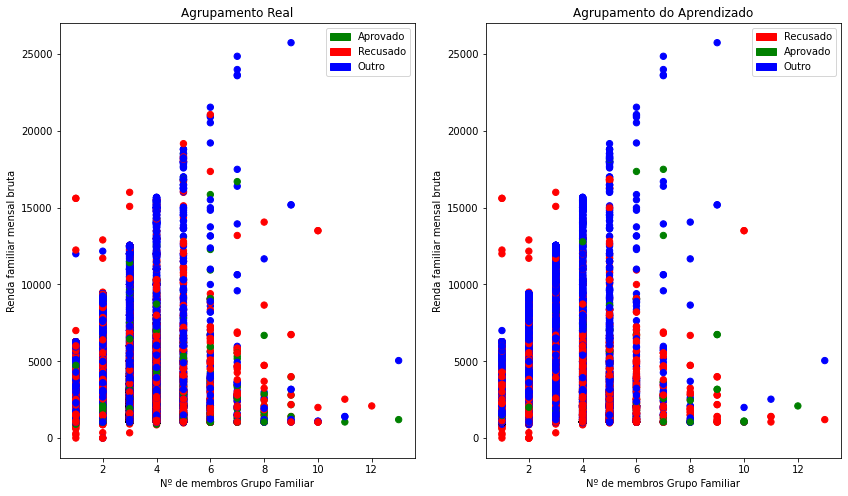

In [12]:
plotPredictSuper("Nº de membros Grupo Familiar", "Renda familiar mensal bruta", X_test, Y_Result, Y_knn)

##### Ano do Enem x Média nota Enem

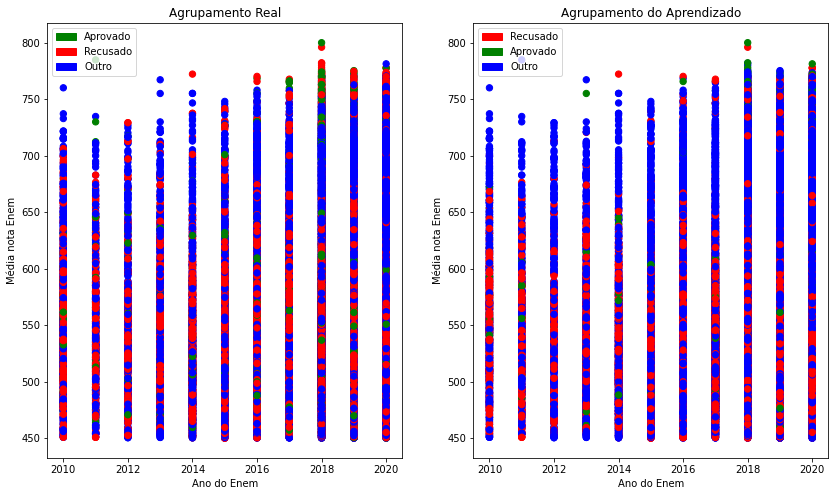

In [13]:
plotPredictSuper("Ano do Enem", "Média nota Enem", X_test, Y_Result, Y_knn)

##### Redação x Média nota Enem

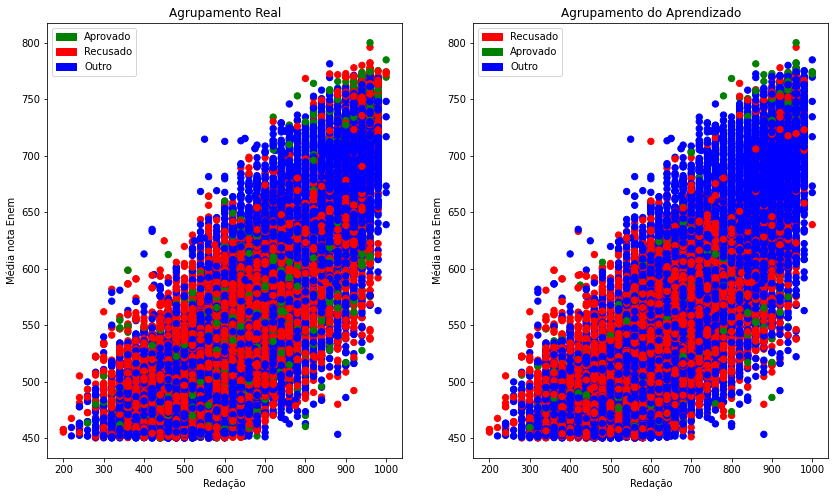

In [14]:
plotPredictSuper("Redação", "Média nota Enem", X_test, Y_Result, Y_knn)

### Árvore de decisão

In [15]:
from sklearn import tree

dtc=tree.DecisionTreeClassifier()
dtc.fit(X_train,Y_train)

dtc_Y_predicted = dtc.predict(X_test)


#### Avaliando estatísticas do modelo gerado

In [16]:
getStatistics(Y_test, dtc_Y_predicted)

Acuracia:65.43%
Precisão: 52.83%
Revogação: 53.08% 

Matriz Confusa: 
[[  872  1501  1626]
 [ 1707 19221  6162]
 [ 1740  6186 15713]] 



#### Avaliando de forma visual

Para possibilitar que uma análise mais visual fosse gerada, gráficos foram plotados, onde os atributos comparados são informados para a função "plotPredictSuper", a qual foi criada previamente, no início do documento

In [17]:
#Tratando os resultados para plotar grafico

Y_dtc = []

for i in range(len(dtc_Y_predicted )):
    Y_dtc.append(getColor(dtc_Y_predicted[i]))
   

##### Nº de membros Grupo Familiar x Renda familiar mensal bruta

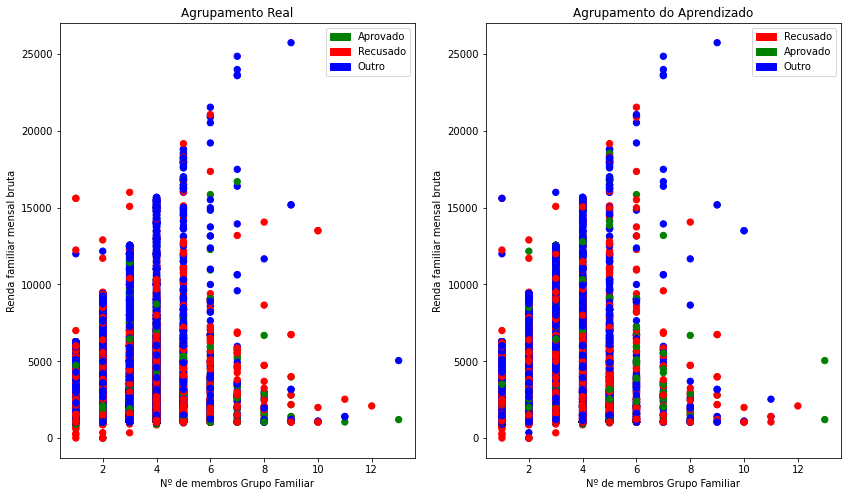

In [18]:
plotPredictSuper("Nº de membros Grupo Familiar", "Renda familiar mensal bruta", X_test, Y_Result, Y_dtc)

##### Redação x Média nota Enem

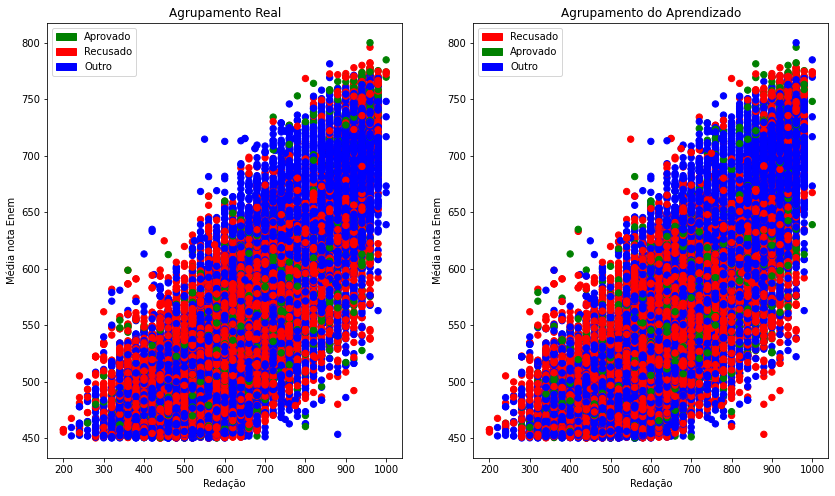

In [19]:
plotPredictSuper("Redação", "Média nota Enem", X_test, Y_Result, Y_dtc)

### Visando aplicar outros algoritmos de aprendizado supervisionado, fez-se um novo conjunto de testes com novas colunas de interesse

In [34]:
cols_interesse = [
                "Nº de membros Grupo Familiar",
                "Renda familiar mensal bruta",
                "Renda mensal bruta per capita", 
                "Opções de cursos da inscrição",
                "Sexo",  "UF de residência", "Etnia/Cor", "Pessoa com deficiência?", "Concluiu curso superior?"]
     
fies2020_X = fies2020[cols_interesse]
fies2020_X = pd.get_dummies(fies2020_X, columns=["Sexo", "UF de residência", "Etnia/Cor", "Pessoa com deficiência?", "Concluiu curso superior?"])


fies2020_Y = fies2020["Situação Inscrição Fies"]

X_train, X_test, Y_train, Y_test = train_test_split(
    fies2020_X,
    fies2020_Y,
    test_size=0.3,
    random_state=0
)

#Usado para plotar no grafico, passo categoria para númerico

Y_Result = list(Y_test.apply(lambda x: getColor(x)))

### SVM

Aplicando um outro algoritmo, também citado em aula, o qual é denominado como SVM

In [21]:
from sklearn import svm

svm = svm.SVC(kernel='linear', max_iter=10000)
svm.fit(X_train, Y_train)

svm_Y_predicted = svm.predict(X_test)
svm_accuracy = np.sum(svm_Y_predicted == Y_test) / len(Y_test)

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


#### Avaliando estatísticas do modelo gerado

In [22]:
getStatistics(Y_test, svm_Y_predicted)

Acuracia:39.04%
Precisão: 44.79%
Revogação: 44.82% 

Matriz Confusa: 
[[ 2164    93  1742]
 [ 5602  1615 19873]
 [ 5556   496 17587]] 



#### Avaliando de forma visual

Para possibilitar que uma análise mais visual fosse gerada, gráficos foram plotados, onde os atributos comparados são informados para a função "plotPredictSuper", a qual foi criada previamente, no início do documento

In [23]:
#Tratando os resultados para plotar grafico

Y_svm = []

for i in range(len(svm_Y_predicted )):
    Y_svm.append(getColor(svm_Y_predicted[i]))
   

##### Nº de membros Grupo Familiar x Renda familiar mensal bruta

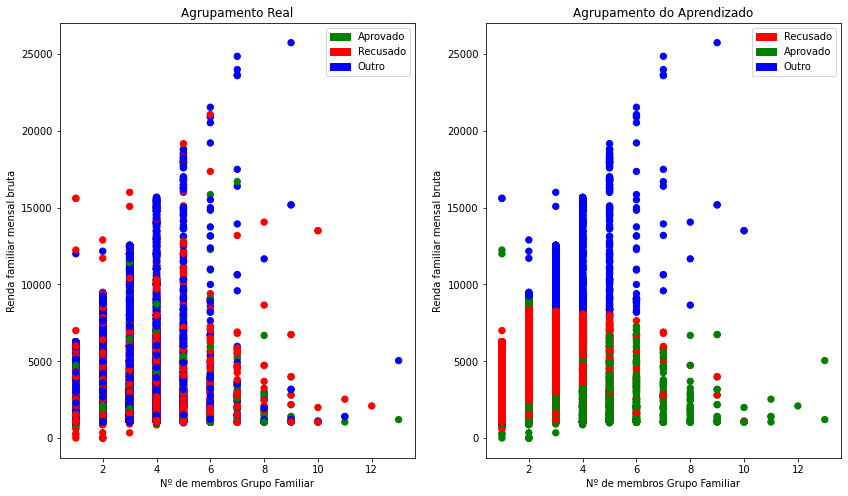

In [24]:
plotPredictSuper("Nº de membros Grupo Familiar", "Renda familiar mensal bruta", X_test, Y_Result, Y_svm)

##### Renda mensal bruta per capita x Opções de cursos da inscrição

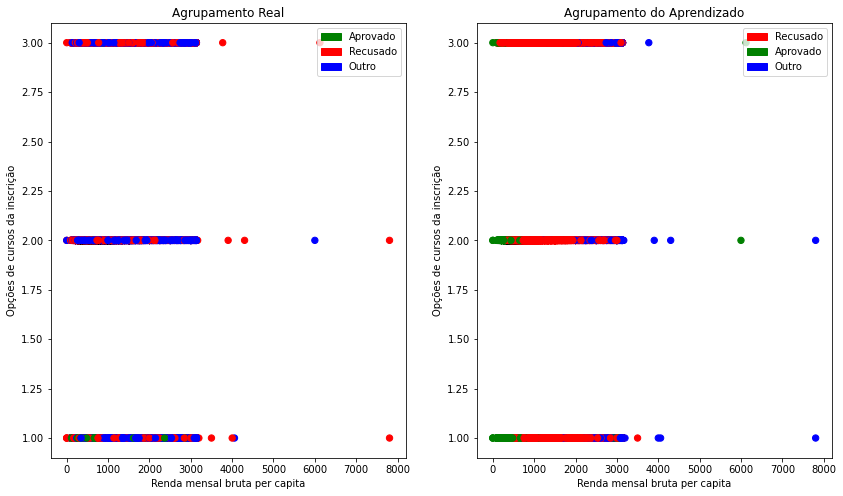

In [28]:
plotPredictSuper("Renda mensal bruta per capita","Opções de cursos da inscrição", X_test, Y_Result, Y_svm)

### PCA

* É basicamente um procedimento não dependente no qual reduz o espaço de atributos de um grande número de variáveis ​​para um menor número de fatores.

* PCA é basicamente um processo de redução de dimensão, mas não há garantia de que a dimensão seja interpretável.

* principal tarefa neste PCA é selecionar um subconjunto de variáveis ​​de um conjunto maior, com base em quais variáveis ​​originais têm a correlação mais alta com o valor principal.

In [29]:
# performing preprocessing part
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
 
X_train = sc.fit_transform(X_train)
X_testl = sc.transform(X_test)

In [30]:

from sklearn.decomposition import PCA
 
pca = PCA(n_components = 2)
 
X_train = pca.fit_transform(X_train)
X_testl = pca.transform(X_testl)
 
explained_variance = pca.explained_variance_ratio_

In [31]:

from sklearn.linear_model import LogisticRegression 
 
classifier = LogisticRegression(random_state = 0)
classifier.fit(X_train, Y_train)

pca_Y_predicted = classifier.predict(X_testl)

#### Avaliando estatísticas do modelo gerado

In [32]:
getStatistics(Y_test, pca_Y_predicted)

Acuracia:51.07%


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Precisão: 33.71%
Revogação: 36.28% 

Matriz Confusa: 
[[    0  2287  1712]
 [    0 17442  9648]
 [    0 13131 10508]] 



#### Avaliando de forma visual

Para possibilitar que uma análise mais visual fosse gerada, gráficos foram plotados, onde os atributos comparados são informados para a função "plotPredictSuper", a qual foi criada previamente, no início do documento

In [33]:

Y_pca = []

for i in range(len(pca_Y_predicted )):
    Y_pca.append(getColor(pca_Y_predicted[i]))

##### Nº de membros Grupo Familiar x Renda familiar mensal bruta

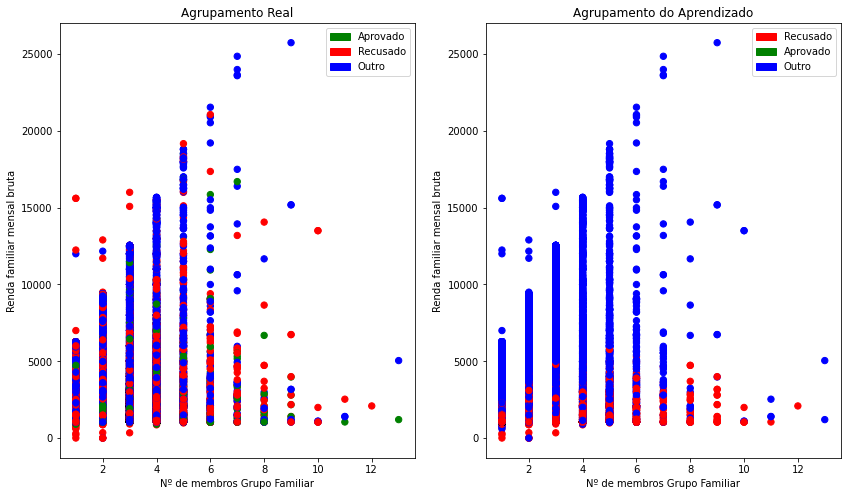

In [34]:
plotPredictSuper("Nº de membros Grupo Familiar", "Renda familiar mensal bruta", X_test, Y_Result, Y_pca)

##### Renda mensal bruta per capita x Opções de cursos da inscrição

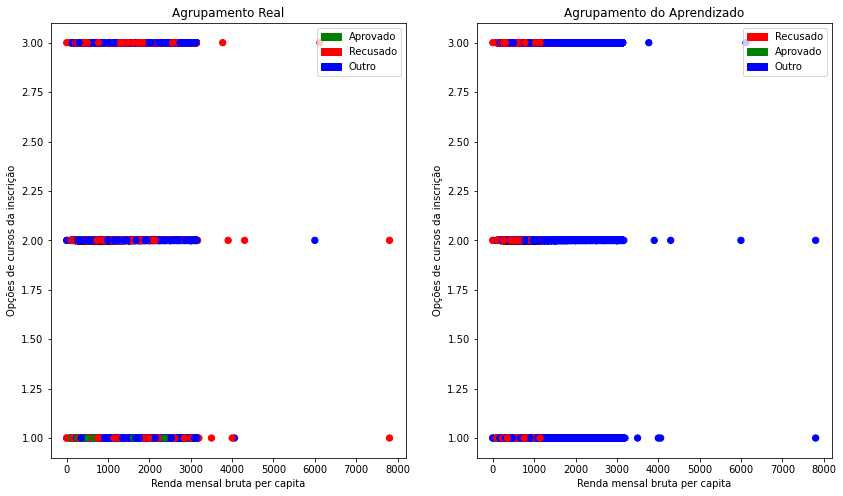

In [36]:
plotPredictSuper("Renda mensal bruta per capita","Opções de cursos da inscrição", X_test, Y_Result, Y_pca)

#### Conclusão

A partir dos algoritmos avaliados, pode-se concluir que os que geraram melhores modelos foram o KNN e o da árvore de decisão, o que pode ser observado pelos gráficos comparativos entre os valores previstos e valores reais, bem como nas estatísticas geradas acerca de cada modelo.

### Aprendizado não supervisionado

Neste momento, aplicaremos algoritmos de aprendizado não supervisionado para visualizar se é possível agrupar os dados da situação do FIES em clusters bem definidos

In [37]:

def plotPredictNoSuper(feature1, feature2, df, target, fx, label):
    # Ajusta o tamanho do gráfico a ser plotado
    plt.figure(figsize=(14, 7))
    
    green_patch = mpatches.Patch(color='green', label='Aprovado')
    red_patch = mpatches.Patch(color='red', label='Recusado')
    blue_patch = mpatches.Patch(color='blue', label='Outro')
        
    cmap_real = np.array(['green','red', 'blue'])

    # Agrupamentos originais/reais
    plt.subplot(1, 2, 1)
    plt.scatter(x=df[feature1], y=df[feature2],  c=cmap_real[df[target].apply(lambda x: fx(x))], s=40)
    plt.title('Agrupamento Real')
    plt.xlabel(feature1)
    plt.ylabel(feature2)
    plt.legend(handles=[ green_patch, red_patch, blue_patch])
    #Modelo
    plt.subplot(1, 2, 2)

    plt.scatter(x=df[feature1], y=df[ feature2],  c=cmap_real[label], s=40)
    plt.title('Agrupamento do Aprendizado')
    plt.xlabel(feature1)
    plt.ylabel(feature2)

    plt.show()

#### K-Means

Este algoritmo, conforme visto em aula, é um algoritmo muito bom. Além disso, ele é vantajoso no contexto em questão visto que é possível definir a quantidade de cluesters desejado que, no caso, equivale à quantidade de categorias utilizadas na situação da inscrição do FIES

In [38]:
from sklearn import datasets, cluster

     
X = fies2020_X

k_means = cluster.KMeans(n_clusters=3)
k_means.fit(X)



KMeans(n_clusters=3)

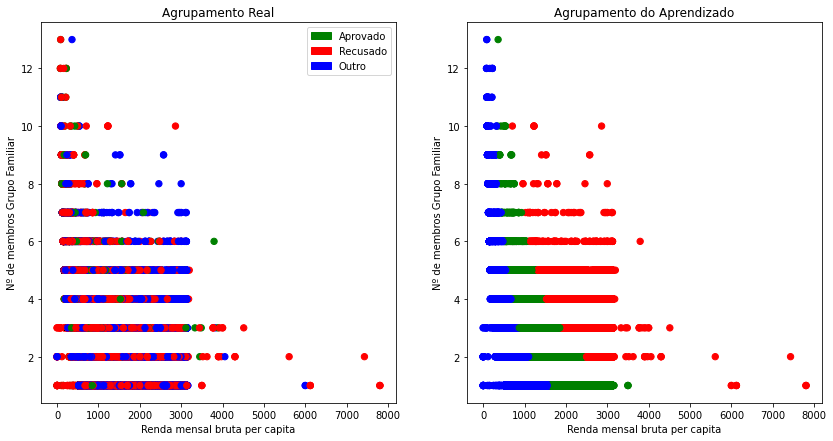

In [39]:
plotPredictNoSuper("Renda mensal bruta per capita",
                    "Nº de membros Grupo Familiar",
                    fies2020,
                    "Situação Inscrição Fies",
                    getColor,
                    k_means.labels_)


#### Conclusão

Conforme é possível observar, não foram definidos clusters que representam bem os dados em contextos reais. Isso pode estar relacionado à alta sobreposição de dados presente no dataset. De tal forma, a classificação de que um inscrito vai ser aceito ou não é mais válida do que sua agrupação em clusters